# PileCore

______________________________________________________________________

**Authors: Thijs Lukkezen & Robin Wimmers**

This notebook shows how to perform a pile bearing calculation with PileCore for multiple CPTs.

The structure of the tutorial is as follows:

- [Project definition](#Input-definition)
- [Download CPT's in project](#Download-CPTs-in-project)
- [Classify CPTs](#Classify-CPTs)
- [Call PileCore-API](#Call-PileCore-API)
- [View Results](#View-Results)
- [Report](#Report)

As usual, we start to install and import the libraries that are needed for this notebook.

In [1]:
import datetime
import os
import io
from typing import Any, Dict, Mapping, Tuple

import numpy as np
import pandas as pd
import pygef
from matplotlib import pyplot as plt
from nuclei.client import NucleiClient
from pypilecore.input import create_multi_cpt_payload
from pypilecore import api
from pypilecore.results import MultiCPTBearingResults, GrouperResults
from tqdm import tqdm

pd.set_option("display.max_columns", None)

### Start a Nuclei client session

In the next cell we will create a nuclei-client with a session that takes care of the
authentication and communication with the Nuclei server.

You will need to provide your user token, which can be obtained by login in to the [nuclei website](https://nuclei.cemsbv.io/) with your personal credentials and going to the "API Access Tokens" section.

<div style="background: #f2ed4c;
            width: 100%;
            color: black;
            text-align: center;">
<b>USER INPUT REQUIRED BELOW:<b>
</div>

In [2]:
# os.environ["NUCLEI_TOKEN"] = "<YOUR TOKEN>"

client = NucleiClient()

# Input definition

#### General input

In [3]:
# General input data
project_id = 21305  # also used to select cpt
project_remark = "Voorbeeld Notebook"  # Optional additional information
author = "N. Uclei"
project_name = "Automated pile design"

#### Soil Investigation input

In [4]:
# Specify CPT selection from project

# ** cpt_selection
# Specify a list of CPTs names (i.e. BRO ID).
cpt_selection = [
    "CPT000000200908",
    "CPT000000200909",
    "CPT000000112272",
    "CPT000000112268",
    "CPT000000112278",
    "CPT000000200904",
    "CPT000000200905",
    "CPT000000112265",
    "CPT000000200906",
    "CPT000000200907",
]


# ** classify_metode:
# Metode used to classify CPT data.
# Accepted values: ["beenJefferies", "machineLearning", "nen", "table", "robertson", "table"]
classify_metode = "robertson"

#### Geometry input

In [5]:
# ** pile_tip_levels_nap
# These are the levels (w.r.t. NAP) at which the bearing capacities will be calculated
# It can be a list, or any other sequence, such as a numpy array.
pile_tip_levels_nap = np.arange(-16, -20, -0.5)

# ** pile_head_level_nap
# The level of the pile-head [m] w.r.t. NAP.
# Must be a number, or the string "surface". In the latter case, the pile-head will be
# situated at the level of the original CPT surface level.
pile_head_level_nap = "surface"

# ** groundwater_level
# The groundwater-level in the project (w.r.t. NAP). Will have an impact on the
# classification and on the calculated soil-stresses.
# When None, the water-level of the CPTs is used.
groundwater_level_nap = None

#### Excavation input

In [6]:
# ** excavation_depth_nap:
# The depth [m w.r.t. NAP] of the service-level after excavation.
# Has to be below the origin al service-level of the CPT.
excavation_depth_nap = None

# ** excavation_param_t:
# Required when providing an excavation_depth. The values can be:
# - 1.0: if installation is not low in vibration (niet-trillingsarm) and piles are installed after excavating
# - 0.5: (wortel-methode) if piles have been installed before excavation or installation is low-vibrating
excavation_param_t = None

#### Construction and loads input

In [7]:
# ** stiff_construction:
# The stiffness of the construction has an influence on the value of xi.
# Accepted values: [True, False]
stiff_construction = False

# ** pile_load_sls:
# The load on the pile-head [kN] (in serviceability state / SLS)
# if None, A fraction of the bearing capacity is used as load to calculate the pile settlement + pile shortening
# Accepted values: > 0.0
pile_load_sls = None

# ** relative_pile_load:
# The fraction of the bearing capacity that is mentioned at `pile_load_sls`.
# If None, the default is 0.7 (i.e. 70%)
# Accepted values: between 0.0 and 1.0
relative_pile_load = None  #

# ** soil_load_sls:
# The overburden-pressure at surface-level [kPa]
# If None, the default is 0.0
soil_load_sls = None

#### Negative Friction input

In [8]:
# ** negative_shaft_friction
# A fixed value of the negative-shaft friction force [kN].
# All other negative-friction settings will be ignored if you fill this.
# Accepted values: > 0.0
negative_shaft_friction = None

# ** friction_range_strategy
# Determination of the positive and negative friction strategy
# For manual determination use 'manual', else 'lower_bound' or 'settlement_driven'
friction_range_strategy = "lower_bound"

# Only used with friction range strategy "manual"
fixed_negative_friction_range_nap = (0.0, -5.0)
fixed_positive_friction_range_nap = (-5.0, "ptl")

# ** Overrule ranges for specific CPTs
# If desired, you can also specify friction ranges per CPT
# The values provided below will overwrite the friction ranges for those specific CPTs.

# ** set_positive_friction_range_nap
# dictionary with key cpt name and value a tuple with upper and lower bound
# e.g.: {"S03": (-17.5, 'ptl')}
set_positive_friction_range_nap: Mapping[Any, Tuple[float, str]] = {}

# ** set_negative_friction_range_nap
# dictionary with key cpt name and value a tuple with upper and lower bound
# e.g.: {"S03": (-5.5, -17.5)}
set_negative_friction_range_nap: Mapping[Any, Tuple[float, str]] = {}

#### Safety Factors input

In [9]:
# ** gamma_r_b
# Safetyfactor on the pile-tip bearing capacity
# If None, the default is 1.2
gamma_r_b = 1.2

# ** gamma_r_s
# Safetyfactor on the sleeve-friction bearing capacity
# If None, the default is 1.2
gamma_r_s = 1.2

# ** gamma_f_nk
# Safetyfactor on the negative friction
# Note: Use 1.4 if bottom negative friction ≠ positive friction
# If None, the default is 1.0
gamma_f_nk = 1.0

# ** overrule_xi
# Sets a fixed value for xi
overrule_xi = None

## Pile input
---

### General specifications

In [10]:
# ** pile_name
# The name of the pile (For potential plotting purposes)
pile_name = None

# ** pile_type
# The English-equivalent of the "Type" section in the table below.
# Accepted values: ["concrete", "steel", "micro", "wood"]
pile_type = "concrete"

# ** specification
# The English-equivalent of the "Specificatie" section in the table below.
specification = "3"

# ** installation
# The English-equivalent of the "Installatie" section in the table below.
installation = "D"

# ** pile_shape
# The shape of the pile
# Accepted values: ["round", "rect"]
pile_shape = "round"

# ** apply_qc3_reduction
# Determines if the reduction on the qc;III trajectory for auger piles should be applied
# conform 7.6.2.3(e) of NEN 9997-1. If None, the value is inferred from the pile type:
# only True for auger piles. If a boolean is provided, the qc3 reduction is/isn't
# applied, regardless of the pile type.
apply_qc3_reduction = None

![](img/table_piles.png)

### Rectangular pile dimensions

Only fill these values if the `pile_shape` == "rect". Otherwise they are ignored

In [11]:
# ** width_base_large
# Largest dimension of the pile base [m].
width_base_large = 0.40

# ** width_base_small
# Smallest dimension of the pile base [m].
# If None, a square base is inferred, with `width_base_large` as dimension.
width_base_small = None

# ** height_base
# Height of pile base [m]. If None, a pile with constant dimension is inferred.
# Cannot be None if the shaft dimensions are not equal to the base dimensions.
height_base = None

# ** width_shaft_large
# Largest dimension of the pile shaft [m]. If None, `width_base_large` is used as
# largest shaft dimension.
width_shaft_large = None

# ** width_shaft_small
# Smallest dimension of the pile shaft [m]. If None, but `width_shaft_large` is not None,
# then a square shaft is inferred, with `width_shaft_large` as dimension. If both
# `width_shaft_small` and `width_shaft_large` are None, then the shaft dimensions are
# equal to the base dimensions.
width_shaft_small = None

### Round pile dimensions

Only fill these values if the `pile_shape` == "round". Otherwise they are ignored

In [12]:
# ** diameter_base
# Base diameter [m].
diameter_base = 0.40

# ** height_base
# Height of pile base [m]. If None, a pile with constant dimension is inferred. Cannot
# be None if diameter_base and diameter_shaft are unequal.
height_base = None

# ** diameter_shaft
# Diameter of pile shaft [m]. If null, a pile with constant diameter (diameter_base) is
# inferred.
diameter_shaft = None

### Optionally overwriteable pile input

If you want to use the default pile specifications you can ignore this section. Any
value provided will overwrite the default value.

In [13]:
# Optional Input

# ** settlement_curve
# Settlement lines for figures 7.n and 7.o of NEN-9997-1 As defined in table 7.c of
# NEN-9997-1. The value is inferred from the pile_type_specifications, but can be
# overwritten
settlement_curve = None

# ** adhesion
# Optional adhesion value, use it if the pile shaft has undergone a special treatment.
# Examples:
# - adhesion = 50 kN/m2 for synthetic coating
# - adhesion = 20 kN/m2 for bentonite
# - adhesion = 10 kN/m2 for bitumen coating
# See 7.3.2.2(d) of NEN 9997-1 for examples.
adhesion = None  # kPa

# ** alpha_p
# Alpha p factor used in pile tip resistance calculation. The value is inferred from the
# pile_type_specifications, but can be overwritten.
alpha_p = None

# ** alpha_s_clay
# Alpha s factor for soft layers used in the positive friction calculation. If None the
# factor is determined as specified in table 7.d of NEN 9997-1.
alpha_s_clay = None

# ** alpha_s_sand
# Alpha s factor for coarse layers used in the positive friction calculation. The value
# is inferred from the pile_type_specifications, but can be overwritten.
alpha_s_sand = None

# ** beta_p
# Factor s used in pile tip resistance calculation as per NEN 9997-1 7.6.2.3 (h). The
# value is inferred from the pile dimension properties, but can be overwritten.
beta_p = None

# ** pile_tip_factor_s
#
pile_tip_factor_s = None

# ** elastic_modulus
# Modulus of elasticity of the pile [MPa]. The value is inferred from the
# pile_type_specifications, but can be overwritten.
elastic_modulus = None

# ** is_auger
# Determines weather the pile the pile is an auger pile or not. The value is inferred
# from the pile_type_specifications, but can be overwritten.
# Accepted values: [True, False, None]
is_auger = None

# ** is_low_vibrating
# Determines weather the pile has an installation type with low vibration. The value is
# inferred from the pile_type_specifications, but can be overwritten.
# Accepted values: [True, False, None]
is_low_vibrating = None

# ** negative_fr_delta_factor
# factor * φ = δ. This parameter will be multiplied with phi to get the delta parameter
# used in negative friction calculation according to NEN-9997-1 7.3.2.2 (e). Typically
# values are 1.0 for piles cast in place, and 0.75 for other pile types. The value is
# inferred from the pile_type_specifications, but can be overwritten.
negative_fr_delta_factor = None

### Other input

Some other input values.

Look [here](https://www.almere.nl/fileadmin/user_upload/Richtlijnen_Constructie_Gem._Almere_vanaf_01-01-2017_versie_3.0a.pdf) for more info about the Almere rules.

In [14]:
# ** use_almere_rules
# If set to True the contribution, produced by the positive shaft friction, to the total
# bearing capacity is limited to at most 75% the contribution provided by the pile tip.
use_almere_rules = None

### Report content

These values define the content of the report

In [15]:
# ** group_results_content
# Whether or not to add a section with the results of all CPTs considered as one
# statistical group.
# Accepted values: [True, False]
group_results_content = True

# ** individual_cpt_results_content
# Whether or not to add a separate result section for each individual CPT.
# Accepted values: [True, False]
individual_cpt_results_content = True

# ** result_summary_content
# Whether or not to add a summary of all results in the beginning of the report.
# Accepted values: [True, False]
result_summary_content = True

<div style="background: #f2ed4c;
            width: 100%;
            color: black;
            text-align: center;">
<b>END USER INPUT<b>
</div>

After this point, modifications are for expert users

#### Download CPTs in project

In [16]:
# Get CPTs
# loop over the cpt id's and fetch file from BRO
cptdata_objects = []
classify_tables: Dict[str, dict] = {}
for file_metadata in tqdm(cpt_selection, desc="Download and classify CPT from BRO"):
    # download CPT from BRO
    response = client.session.get(
        url=f"https://publiek.broservices.nl/sr/cpt/v1/objects/{file_metadata}"
    )
    if not response.ok:
        print(
            f"RuntimeError: {file_metadata} could not be donwloaded from de BRO server. \n Statuse code: {response.status_code}"
        )
        continue

    cpt = pygef.read_cpt(io.BytesIO(response.content))
    object.__setattr__(cpt, "alias", file_metadata)
    
    data = cpt.data.drop_nulls()

    # classify CPT with CPTCore
    payload = {
        "aggregateLayersPenalty": 5,
        "minimumSegmentLength": 15,
        "data": {
            "coneResistance": data.get_column("coneResistance").clip(0, 50).to_list(),
            "correctedPenetrationLength": data.get_column("depth").to_list(),
            "localFriction": data.get_column("localFriction").clip(0, 50).to_list(),
        },
        "verticalPositionOffset": cpt.delivered_vertical_position_offset,
        "x": cpt.delivered_location.x,
        "y": cpt.delivered_location.y,
    }
    if "porePressureU2" in data.columns:
        payload["data"]["porePressureU2"] = (
            data.get_column("porePressureU2").clip(0, 50).to_list(),
        )[0]

    response = client.session.post(
        f"https://crux-nuclei.com/api/cptcore/v1/classify/{classify_metode}",
        json=payload,
    )
    if not response.ok:
        print(
            f"RuntimeError: {file_metadata} could not be classified. \n Statuse code: {response.status_code}"
        )
        continue

    cptdata_objects.append(cpt)
    classify_tables[file_metadata] = response.json()

Download and classify CPT from BRO: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


#### Call PileCore-API

In [18]:
# Get results

multi_cpt_payload, results_passover = create_multi_cpt_payload(
    cptdata_objects=cptdata_objects,
    classify_tables=classify_tables,
    groundwater_level_nap=groundwater_level_nap,
    friction_range_strategy=friction_range_strategy,
    excavation_depth_nap=excavation_depth_nap,
    individual_negative_friction_range_nap=set_negative_friction_range_nap,
    individual_positive_friction_range_nap=set_positive_friction_range_nap,
    pile_type=pile_type,
    specification=specification,
    installation=installation,
    pile_shape=pile_shape,
    diameter_base=diameter_base,
    diameter_shaft=diameter_shaft,
    width_base_large=width_base_large,
    width_base_small=width_base_small,
    width_shaft_large=width_shaft_large,
    width_shaft_small=width_shaft_small,
    height_base=height_base,
    settlement_curve=settlement_curve,
    adhesion=adhesion,
    alpha_p=alpha_p,
    alpha_s_clay=alpha_s_clay,
    alpha_s_sand=alpha_s_sand,
    beta_p=beta_p,
    pile_tip_factor_s=pile_tip_factor_s,
    elastic_modulus=elastic_modulus,
    is_auger=is_auger,
    is_low_vibrating=is_low_vibrating,
    negative_fr_delta_factor=negative_fr_delta_factor,
    excavation_param_t=excavation_param_t,
    pile_head_level_nap=pile_head_level_nap,
    pile_load_sls=pile_load_sls,
    pile_tip_levels_nap=pile_tip_levels_nap,
    relative_pile_load=relative_pile_load,
    apply_qc3_reduction=apply_qc3_reduction,
    negative_shaft_friction=negative_shaft_friction,
    fixed_negative_friction_range_nap=fixed_negative_friction_range_nap,
    fixed_positive_friction_range_nap=fixed_positive_friction_range_nap,
    gamma_f_nk=gamma_f_nk,
    gamma_r_b=gamma_r_b,
    gamma_r_s=gamma_r_s,
    overrule_xi=overrule_xi,
    soil_load_sls=soil_load_sls,
    use_almere_rules=use_almere_rules,
    stiff_construction=stiff_construction,
    cpts_group=None,
)

api_response = api.get_multi_cpt_api_result(client=client, payload=multi_cpt_payload)

results = MultiCPTBearingResults.from_api_response(
    response_dict=api_response,
    cpt_input=results_passover,
)

Create soil properties payload: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1954.48it/s]


## View Results

In [21]:
# Get the available CPT names
results.cpt_names

['CPT000000200908']

In [24]:
# Select a CPT test-id to display
display_test_id = results.cpt_results["CPT000000200908"]

<Axes: xlabel='[kN]', ylabel='[m] w.r.t. NAP'>

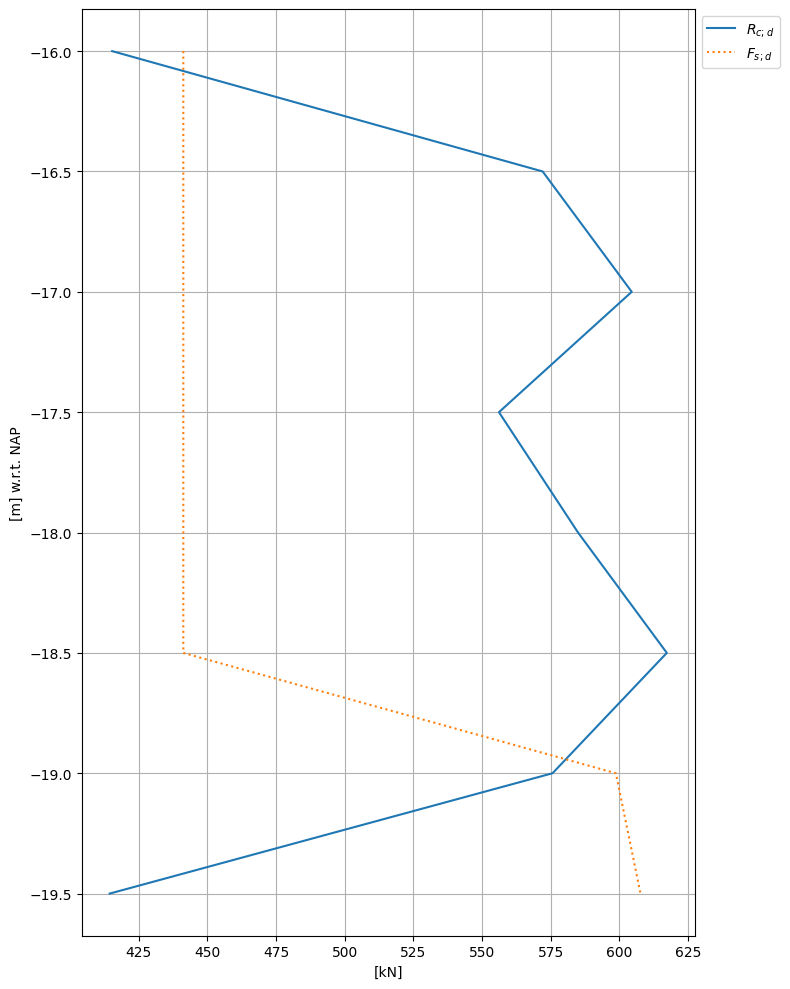

In [29]:
results.group_results_table.plot_bearing_capacities()

AttributeError: 'dict' object has no attribute 'plot_qc'

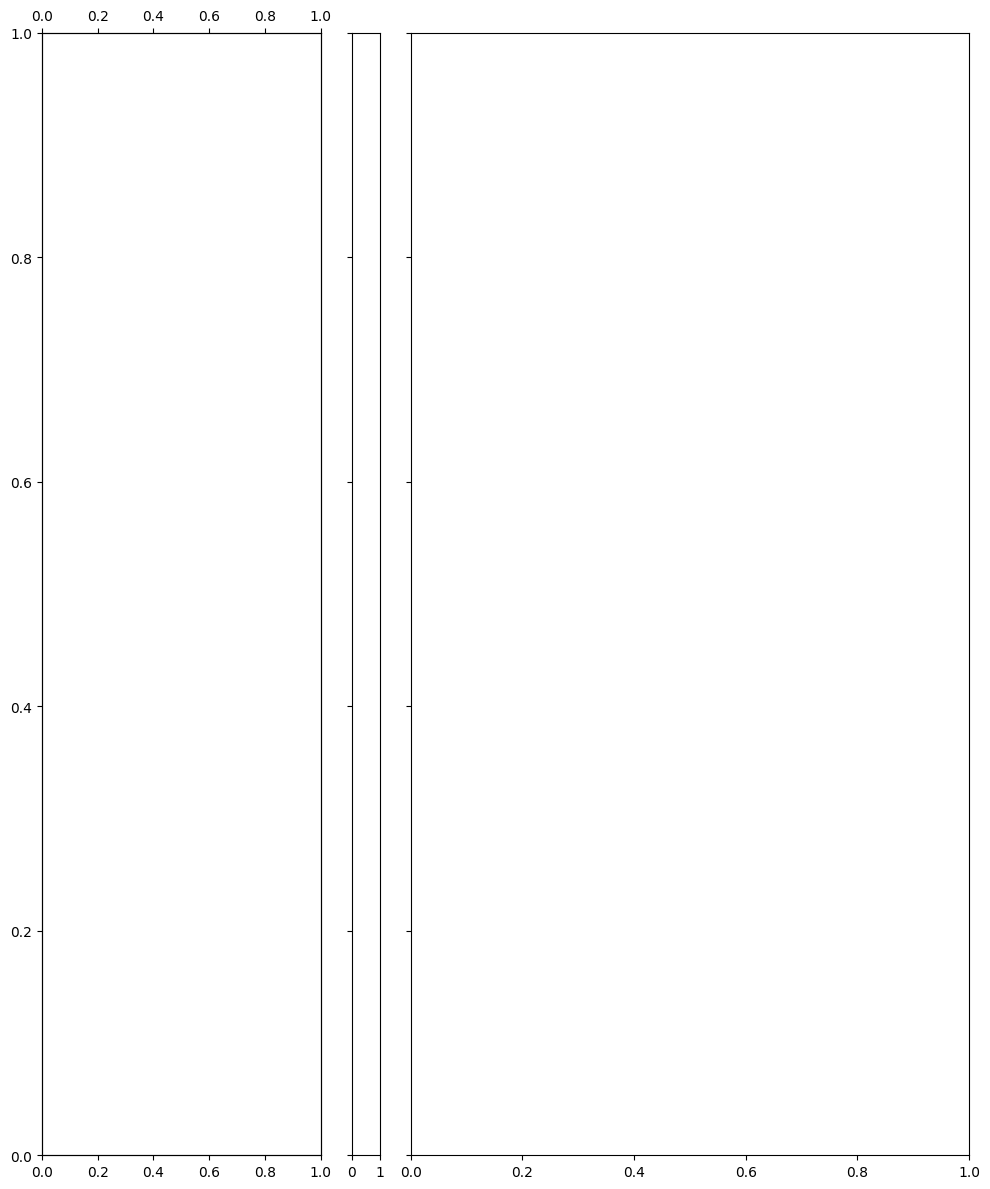

In [26]:
results.get_cpt_results(test_id=display_test_id).plot_bearing_overview();

In [31]:
results.plot_group_bearing_capacities();

AttributeError: 'MultiCPTBearingResults' object has no attribute 'plot_group_bearing_capacities'

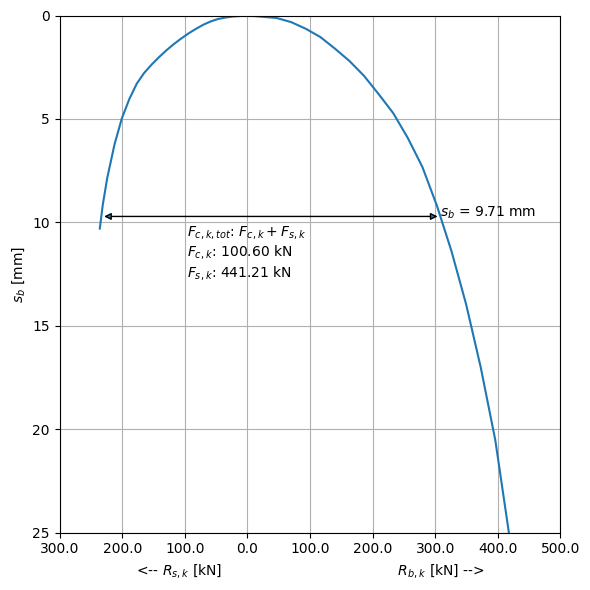

In [34]:
results.plot_load_settlement(-18);

In [35]:
results.group_summary_df.round(2)

AttributeError: 'MultiCPTBearingResults' object has no attribute 'group_summary_df'

Results for individual CPTs

In [ ]:
R_b_cal = results.get_results_per_cpt(column_name="R_b_cal").round(1)
# R_b_cal.to_csv(f"{project_name} puntweerstand (zonder factoren).csv")

print("Puntweerstand (zonder factoren)")
R_b_cal

In [ ]:
R_s_cal = results.get_results_per_cpt(column_name="R_s_cal").round(1)
# R_s_cal.to_csv(f"{project_name} Schachtweerstand (zonder factoren).csv")

print("Schachtweerstand (zonder factoren)")
R_s_cal

In [ ]:
F_nk_cal = results.get_results_per_cpt(column_name="F_nk_cal").round(1)
# F_nk_cal.to_csv(f"{project_name} negatieve kleef.csv")

print("Negatieve kleef")
F_nk_cal

In [ ]:
R_c_cal = results.get_results_per_cpt(column_name="R_c_cal").round(1)
# R_c_cal.to_csv(
#     f"{project_name} paaldraagvermogen individuele sonderingen (zonder factoren).csv"
# )

print("Paaldraagvermogen individuele sonderingen (zonder factoren)")
R_c_cal

In [ ]:
R_c_net_d = results.get_results_per_cpt(column_name="R_c_d_net").round(1)
# R_c_net_d.round(1).to_csv(f"{project_name} rekenwaarde netto paaldraagvermogen.csv")

print("Rekenwaarde netto paaldraagvermogen individuele sonderingen")
R_c_net_d

## Report

In [ ]:
# Create report

# Close all open plots to save memory
plt.close("All")

multi_cpt_report_payload = create_multi_cpt_report_payload(
    multi_cpt_payload=multi_cpt_payload,
    project_name=project_name,
    project_id=str(project_id),
    author=author,
    date=datetime.date.today().strftime("%d-%m-%y"),
    group_results_content=group_results_content,
    individual_cpt_results_content=individual_cpt_results_content,
    result_summary_content=result_summary_content,
)

report = get_multi_cpt_api_report(client=client, payload=multi_cpt_report_payload)

with open(f"{project_name} report.pdf", "wb") as f:
    f.write(report)